# Code review 10: of apf2139 by izrubin

## Review instructions

+ Find the notebook that you are assigned to review in the Code-Review-Map below. If your assigned notebook is not available by the time you go to do your review then choose any notebook in the GitHub repository. 


+ Create a new notebook in the Code-Review directory and name it `<github-username-code-review-10.ipynb`. Use this notebook to test out the code that you are assigned to review, and use markdown to answer the questions below. 

_See below in the notebook for apf2139's tested code._

+ What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?

_They used numpy to generate random data with Poisson data distribution. The generated data represented the "subjective goodness" of Frank Sinatra by his age, based on the lyrics of Sinatra's "Very Good Year" that apf2139 linked at the bottom of the notebook._

+ What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit.

_They used a switchpoint model from pymc3. The model is the same as the class nb-10.6 and the pymc3 tutorial case study 2, but they did not link to the tutorial. They are trying to fit the switchpoint year of 36, after which Sinatra signs of having no more good years. The other parameters to fit are the rating of 10 for the first 36 years, and the rating of 1 for the last 42 years of Sinatra's life._

+ Are they sampling data in their model from the same type of distribution that was used to generate the data?

_Yes, both use Poisson distributions._

+ Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?

_I agree that the model fits well given the original parameters. This could be improved by setting the low-ranked years to start at age 50_ - [_when the album September of My Years for the referenced song was released_](https://en.wikipedia.org/wiki/September_of_My_Years) - _or by generating data showing a gradual decrease in the ranking of the year quality between ages 35 and 50, although the lyrics still hint that even when he sang the song at fifty, it was still a very good year._

+ Commit and push your notebook to the Code Review directory and make a pull request with the course repository. 



In [7]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# fix a random seed
np.random.seed(7)

# generate data
data = pd.DataFrame({
    "Frank_Sinatras_age": np.arange(0, 82),
    "Level_of_subjective_goodness_that_year": np.concatenate([
        np.random.poisson(10.0, 36),
        np.random.poisson(1.0, 46),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 5)
data.loc[missing, "Level_of_subjective_goodness_that_year"] = np.nan

In [9]:
data.head()

Frank_Sinatras_age  Level_of_subjective_goodness_that_year
0                   0                                     9.0
1                   1                                    10.0
2                   2                                     8.0
3                   3                                     9.0
4                   4                                     8.0

In [10]:
data.loc[(17,21,35),]

Frank_Sinatras_age  Level_of_subjective_goodness_that_year
17                  17                                    11.0
21                  21                                    11.0
35                  35                                     9.0

In [11]:
# plot the generated data
toyplot.scatterplot(
    data.Frank_Sinatras_age,
    data.Level_of_subjective_goodness_that_year, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="age", 
    ylabel="goodness",
);

0 25 50 75 age 0 5 10 15 goodness

In [12]:
with pm.Model() as goodness_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.Frank_Sinatras_age.min(), 
        upper=data.Frank_Sinatras_age.max(), 
        testval=40)

    # Priors for pre- and post-switch rates
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.Frank_Sinatras_age, early_rate, late_rate)

    goodness = pm.Poisson('goodness', rate, observed=data.Level_of_subjective_goodness_that_year)

In [13]:
with goodness_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to goodness_missing
100%|██████████| 10500/10500 [01:08<00:00, 153.72it/s]


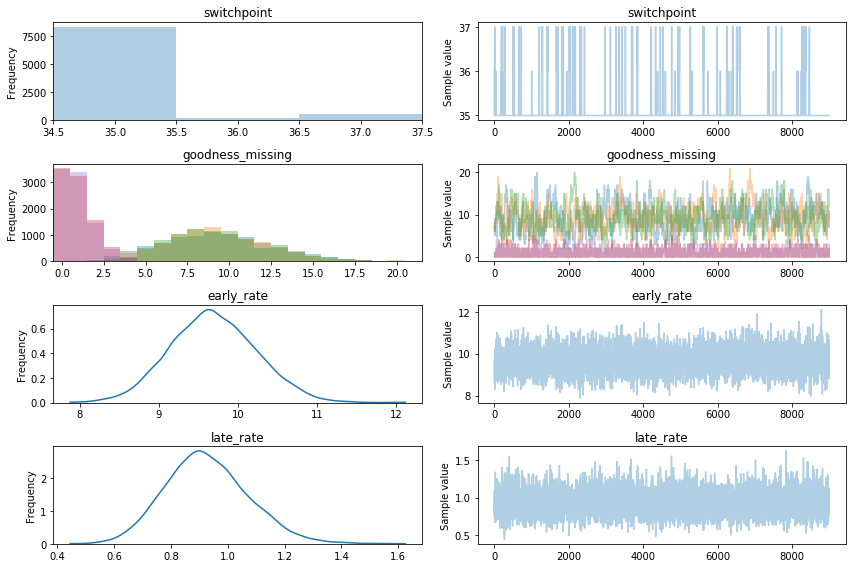

In [14]:
pm.traceplot(trace[1000:]);

In [15]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  35.135           0.481            0.018            [35.000, 37.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  35.000         35.000         35.000         35.000         37.000


goodness_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.375            3.156            0.215            [3.000, 15.000]
  9.324            3.052            0.214            [4.000, 15.000]
  9.271            2.978            0.209            [4.000, 15.000]
  0.925            0.959            0.033            [0.000, 3.000]
  0.940            0.991            0.037            [0.000, 3.000]

  Posterior quantiles:
  2.5         

The model predicted the switchpoint accurately; it detected an mean age of 35.135 as the time at which Frank Sinatra apparently stopped having good years. The true switchpoint of 36 was within the 95% HPD interval.

Early and late rate values matched the input poisson loc fairly well, predicted 9.682 and 0.927 for true 10 and 1 respectively. Both true values were within the 95% HPD interval and both means were slightly below the true values.

The sampler took about a minute to run. I did not encounter any problems running the model.


I also previously ran the model using 35 as an input switchpoint. Curiously, after running several times, the model consistently predicted a mean of only 34 with an HPD interval so small that the decimal place showed 34.000 on both ends of the interval. However, the early and late rates were predicted as above.


https://genius.com/Frank-sinatra-it-was-a-very-good-year-lyrics